In [2]:
from tqdm import tqdm
import random
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
from omegaconf import OmegaConf
from copy import deepcopy
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from cfgen.models.fm.fm import FM
from scvi.distributions import NegativeBinomial

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4)) 

## Initialize dataset and encoder

In [3]:
dataset_conf = OmegaConf.load("../../configs/configs_sccfm/dataset/hlca_core.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/encoder_large.yaml")

Initialize dataset

In [4]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=64,
                                            shuffle=False,
                                            drop_last=False)

in_dim = dataset.X["rna"].shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

Initialize Autoencoder

In [5]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [6]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_hlca_core_final/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

## Initialize Flow Matching model

In [7]:
generative_model_config = OmegaConf.load("../../configs/configs_sccfm/generative_model/default.yaml")

In [8]:
ckpt = torch.load("../../project_folder/experiments/cfgen_ckpt/train_fm_hlca_core_final/last.ckpt", weights_only=False)

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [9]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.0976, -1.1794,  0.6497,  ...,  1.6763,  1.0999,  1.8106],
        [-0.5112,  0.1956,  0.3835,  ..., -0.4125, -0.2150,  0.8190],
        [ 0.0974, -0.3382,  0.2965,  ..., -1.7323, -0.6018, -2.0579],
        ...,
        [-0.7028,  0.7221, -2.0200,  ...,  0.0626, -2.0541,  1.2342],
        [ 1.3872, -0.9133, -0.3087,  ...,  1.2235, -1.0392, -0.2147],
        [ 0.9030,  0.9383,  1.2732,  ...,  2.0454,  1.0047, -1.5304]],
       device='cuda:0', requires_grad=True)


In [10]:
generative_model = FM(encoder_model=encoder_model,
                        denoising_model=denoising_model,
                        feature_embeddings=feature_embeddings,
                        plotting_folder=None,
                        in_dim={"rna": 100},
                        size_factor_statistics=size_factor_statistics,
                        covariate_list=["cell_type"],
                        theta_covariate="cell_type",
                        size_factor_covariate="cell_type",
                        is_binarized=False,
                        modality_list=["rna"],
                        guidance_weights={"cell_type": 1},
                        **generative_model_config  # model_kwargs should contain the rest of the arguments
                        )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (encoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=27997, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=256, out_features=100, bias=True)
        )
      )
    )
    (decoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=100, out_features=256, bias=True)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
        

## Load real dataset 

In [11]:
adata_original = sc.read_h5ad(dataset_conf["dataset_path"].replace("train", "test"))
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.toarray().sum(1)

In [12]:
# Only keep a subset of cells for demonstration
sc.pp.subsample(adata_original, 0.5)

## Generate and save cells

In [13]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B cell': np.int64(434),
 'CD1c-positive myeloid dendritic cell': np.int64(910),
 'CD4-positive, alpha-beta T cell': np.int64(2129),
 'CD8-positive, alpha-beta T cell': np.int64(2807),
 'T cell': np.int64(59),
 'acinar cell': np.int64(130),
 'alveolar macrophage': np.int64(7884),
 'alveolar type 1 fibroblast cell': np.int64(513),
 'alveolar type 2 fibroblast cell': np.int64(1012),
 'bronchial goblet cell': np.int64(192),
 'bronchus fibroblast of lung': np.int64(182),
 'brush cell of trachebronchial tree': np.int64(15),
 'capillary endothelial cell': np.int64(2279),
 'ciliated columnar cell of tracheobronchial tree': np.int64(3595),
 'classical monocyte': np.int64(1740),
 'club cell': np.int64(3630),
 'conventional dendritic cell': np.int64(24),
 'dendritic cell': np.int64(29),
 'elicited macrophage': np.int64(2852),
 'endothelial cell of lymphatic vessel': np.int64(436),
 'epithelial cell of alveolus of lung': np.int64(159),
 'epithelial cell of lower respiratory tract': np.int64(449)

In [16]:
del dataset.X

AttributeError: X

In [15]:
X_generated_list = []  # Will contain generated cells 
classes_str = []  # Will contain annotation 

# Generate in batches -- roughly 18k cells
for _ in tqdm(range(60)):
    num_indices = 1000
    index_range = len(adata_original)
    
    # Sample conditions from the data (roughly keeps the same observed proportions)
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)  
    classes_str += classes
    classes = {"cell_type": torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes])}

    log_size_factors = {"rna": torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()}
    X_generated = generative_model.batched_sample(batch_size=100,
                                                    repetitions=10,
                                                    n_sample_steps=2, 
                                                    theta_covariate="cell_type", 
                                                    size_factor_covariate="cell_type", 
                                                    conditioning_covariates=["cell_type"],
                                                    covariate_indices=classes, 
                                                    log_size_factor=log_size_factors)

    X_generated_list.append(X_generated["rna"].to("cpu"))

100%|██████████| 60/60 [03:18<00:00,  3.30s/it]


In [17]:
X_generated = torch.cat(X_generated_list, dim=0).numpy()

In [18]:
dataset_type = ["Real" for _ in range(adata_original.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [19]:
adata_merged = sc.AnnData(X=np.concatenate([adata_original.X.toarray(), X_generated], axis=0), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

In [21]:
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

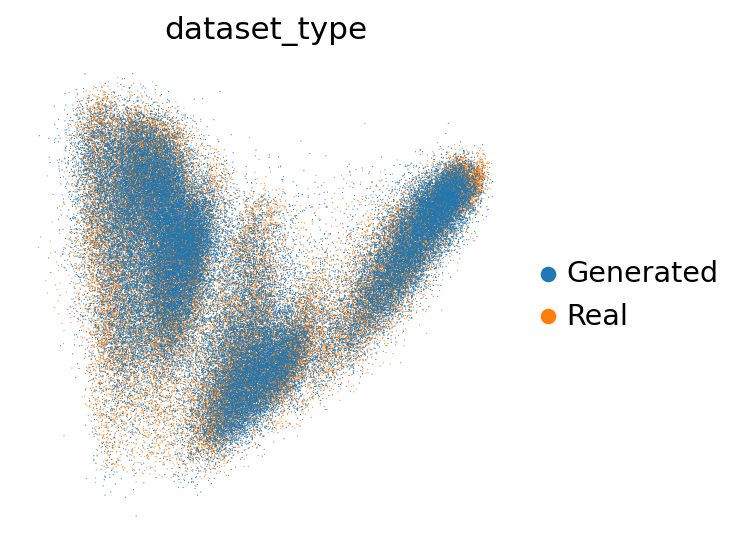

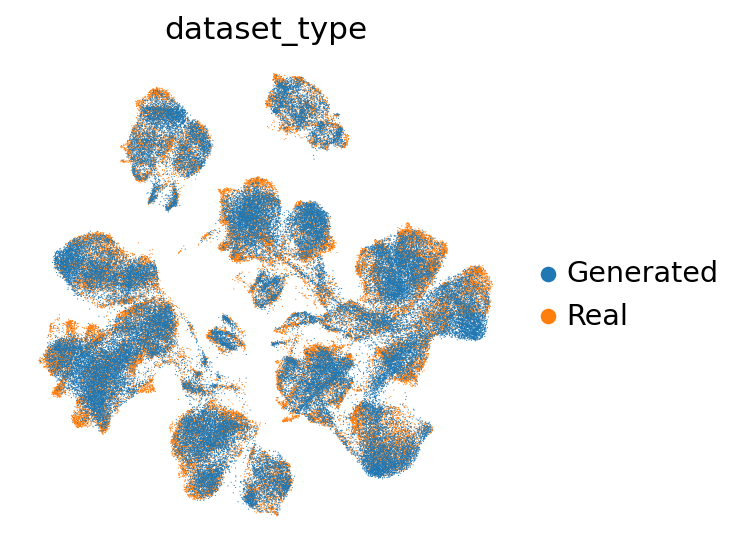

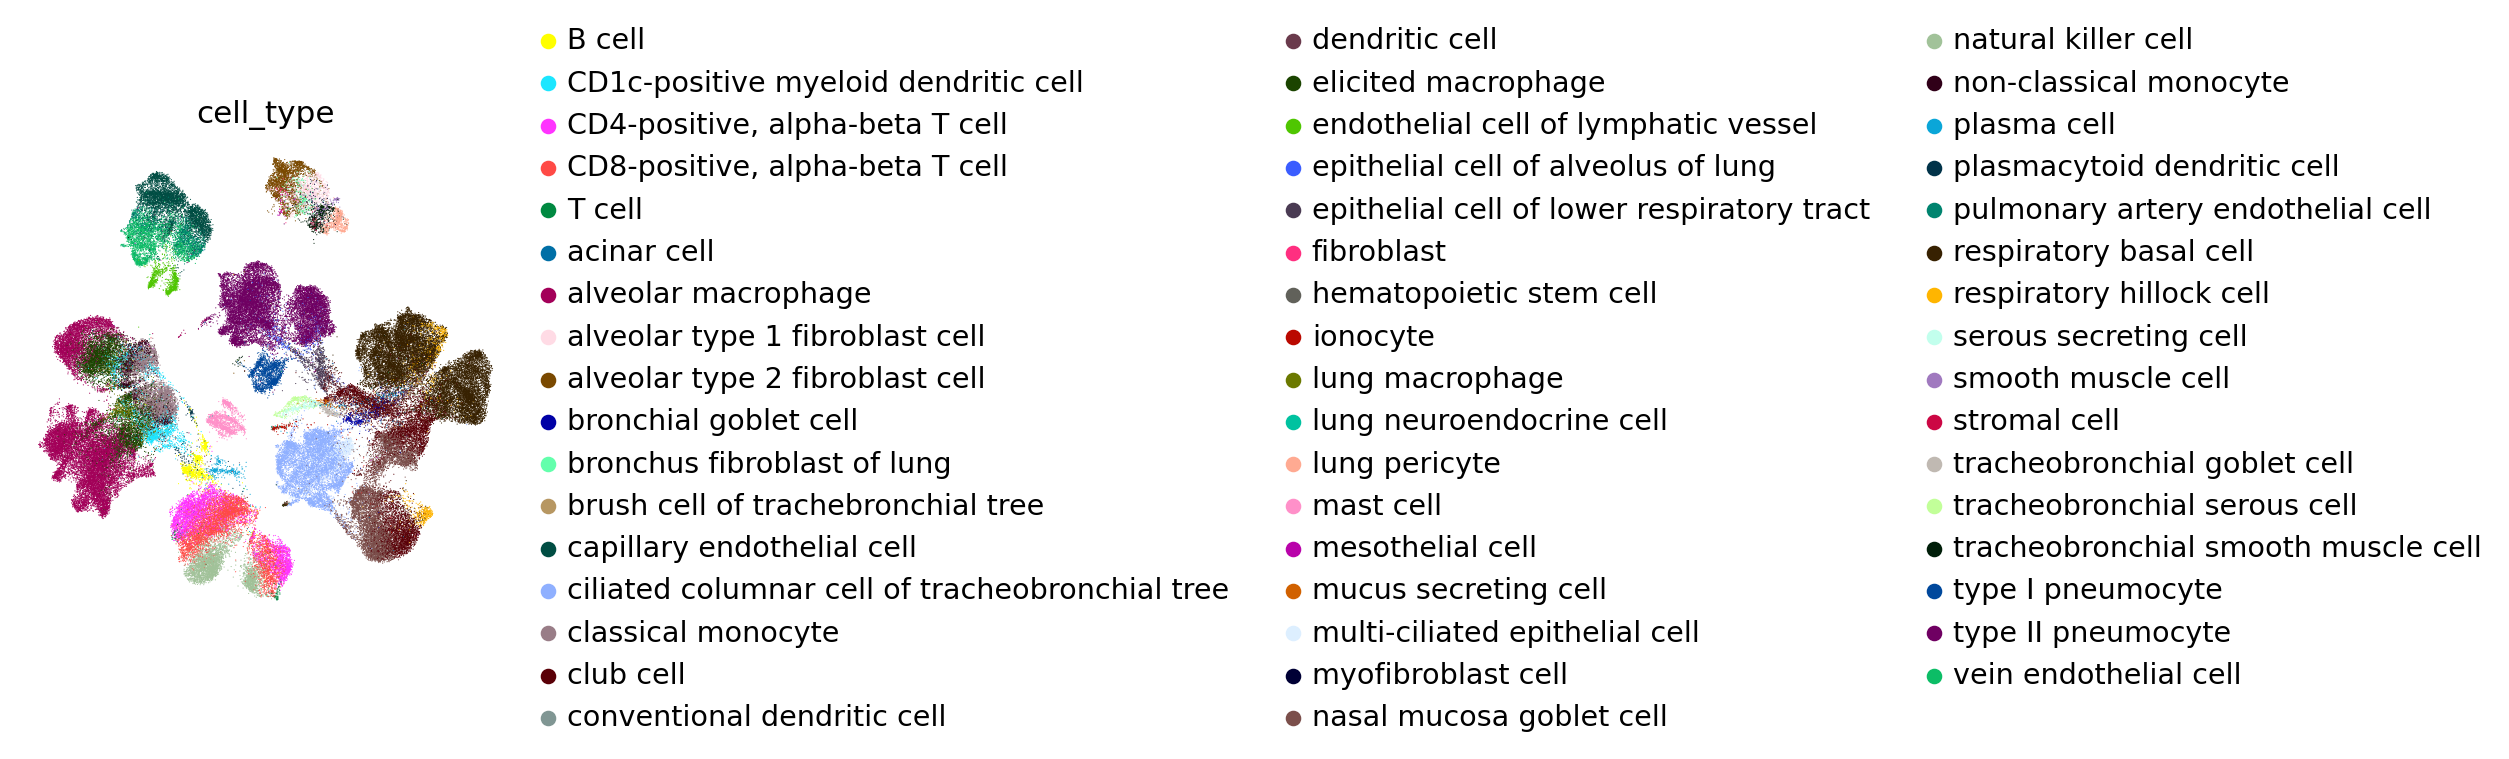

In [22]:
sc.pl.pca(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")